<a href="https://colab.research.google.com/github/SebaAyala/AST_TP_2/blob/main/AST_TP_2_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerias

In [ ]:
!git clone https://github.com/google-research/timesfm.git

Cloning into 'timesfm'...
remote: Enumerating objects: 1111, done.
remote: Counting objects: 100% (492/492), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1111 (delta 356), reused 291 (delta 279), pack-reused 619 (from 3)
Receiving objects: 100% (1111/1111), 2.39 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

from google.colab import drive
from google.colab import auth
from google.auth import default

In [ ]:
creds, _ = default()
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

Mounted at /content/drive


## Carga de datasets

In [ ]:
# Ruta al archivo en tu Google Drive
df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
df_precipitaciones = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/precip.xlsx', skiprows=3)
df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])

/tmp/ipython-input-633792332.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
/tmp/ipython-input-633792332.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])


In [ ]:
print(df_siniestros.head())
print(df_precipitaciones.head())
print(df_temperatura.head())

          id_hecho  n_victimas       fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2  2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1  2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1  2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2  2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1  2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_d

In [ ]:
lista_datasets = [df_siniestros, df_precipitaciones, df_temperatura]
for i in lista_datasets:
  print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44012 entries, 0 to 44011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_hecho               44012 non-null  object
 1   n_victimas             44012 non-null  int64 
 2   fecha                  44012 non-null  object
 3   aaaa                   44012 non-null  int64 
 4   mm                     44012 non-null  int64 
 5   dd                     44012 non-null  int64 
 6   hora                   44012 non-null  object
 7   hh                     44012 non-null  object
 8   direccion_normalizada  44012 non-null  object
 9   calle                  33111 non-null  object
 10  altura                 32665 non-null  object
 11  cruce                  29509 non-null  object
 12  otra_direccion         44012 non-null  object
 13  comuna                 44012 non-null  object
 14  tipo_de_calle          44012 non-null  object
 15  geocodificacion_cab

# Siniestros

In [ ]:
df_siniestros['fecha'] = pd.to_datetime(df_siniestros['fecha'],  errors='coerce')
df_siniestros.head()

,id_hecho,n_victimas,fecha,aaaa,mm,dd,hora,hh,direccion_normalizada,calle,...,comuna,tipo_de_calle,geocodificacion_caba,longitud,latitud,participantes,victima,contraparte,gravedad,tipo_de_dato
0,LC-2019-0008283,2,2019-01-04,2019,1,4,17:53:00,17,SD,NaN,...,SD,SD,SD,SD,SD,AUTO-SD,AUTO,SD,SD,definitivo
1,LC-2019-0007634,1,2019-01-04,2019,1,4,14:50:00,14,SD,NaN,...,SD,SD,SD,SD,SD,MOTO-SD,MOTO,SD,SD,definitivo
2,LC-2019-0008974,1,2019-01-05,2019,1,5,09:30:00,9,SD,NaN,...,SD,SD,SD,SD,SD,BICICLETA-SD,BICICLETA,SD,SD,definitivo
3,LC-2019-0010983,2,2019-01-06,2019,1,6,22:20:00,22,SD,NaN,...,SD,SD,SD,SD,SD,AUTO-SD,AUTO,SD,SD,definitivo
4,LC-2019-0011092,1,2019-01-07,2019,1,7,03:50:00,3,SD,NaN,...,SD,SD,SD,SD,SD,PEATON-SD,PEATON,SD,SD,definitivo


In [ ]:
df_siniestros = df_siniestros.groupby('fecha').size().reset_index(name='cantidad_eventos')
# df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

,fecha,cantidad_eventos
0,2019-01-01,18
1,2019-01-02,16
2,2019-01-03,24
3,2019-01-04,35
4,2019-01-05,19


In [ ]:
df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

,cantidad_eventos
fecha,
2019-01-01,18
2019-01-02,16
2019-01-03,24
2019-01-04,35
2019-01-05,19


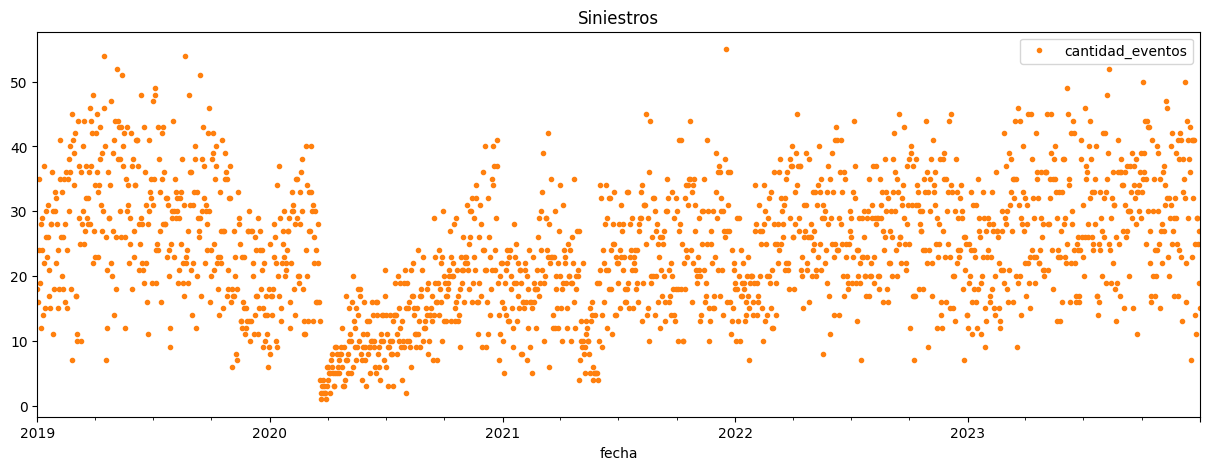

In [ ]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

In [ ]:
print('Cantidad de NaNs:')
for column in df_siniestros:
    nans = df_siniestros[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna cantidad_eventos: 0


Analisis de outliers

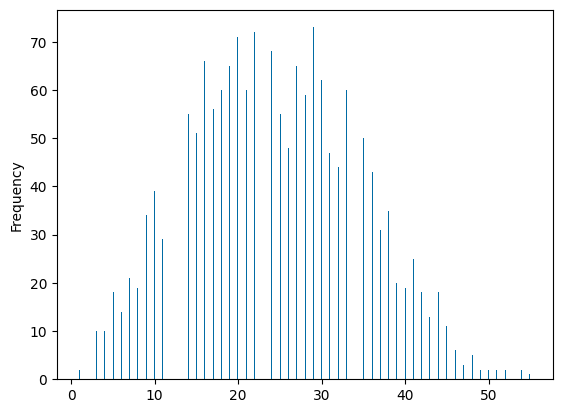

In [ ]:
df_siniestros['cantidad_eventos'].plot(kind='hist', bins=500);

Outliers based on IQR:


,cantidad_eventos
fecha,
2019-04-16,54
2019-08-21,54
2021-12-17,55


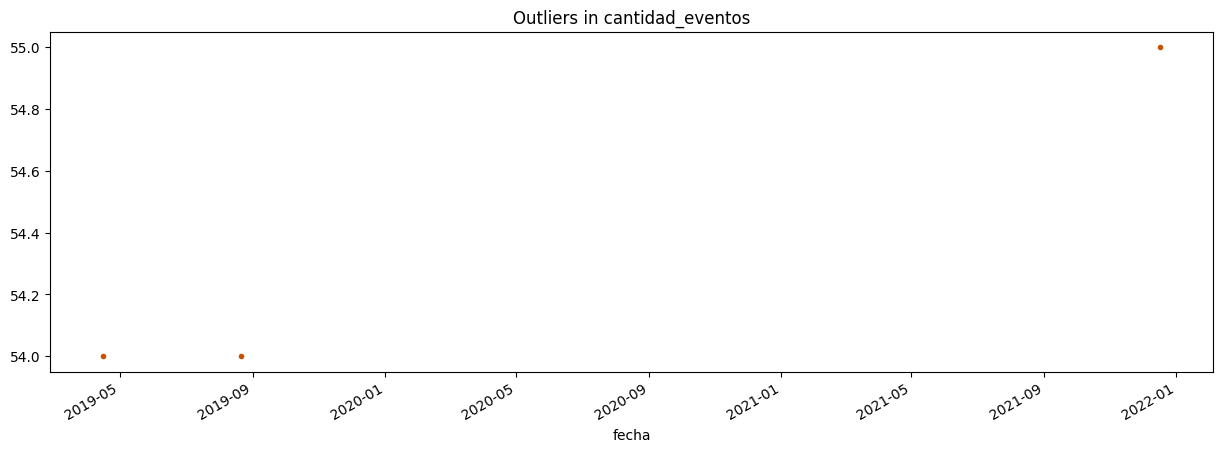

In [ ]:
Q1 = df_siniestros['cantidad_eventos'].quantile(0.25)
Q3 = df_siniestros['cantidad_eventos'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_siniestros[(df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['cantidad_eventos'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in cantidad_eventos')
plt.show()

In [ ]:
#Lo que hago es modificar los outliers por el valor 53, que es el valor menor a que se considere outlier
condicion = (df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)
df_siniestros.loc[condicion, 'cantidad_eventos'] = 53

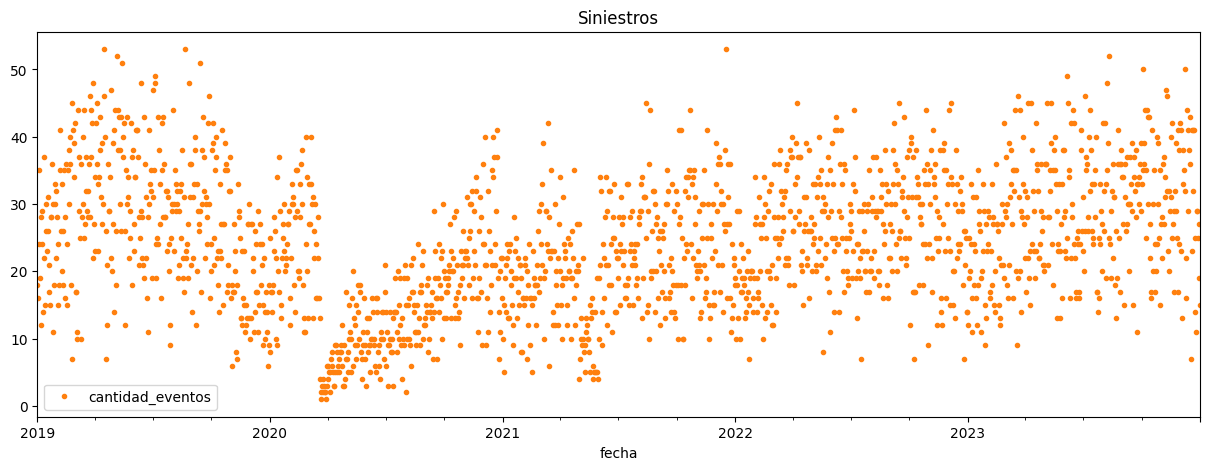

In [ ]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

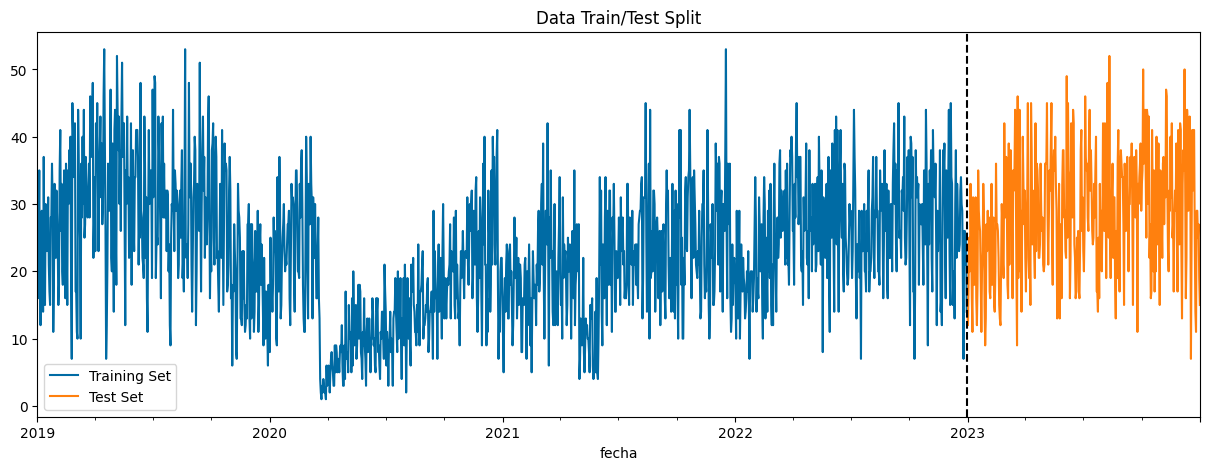

In [ ]:
split_index = int(len(df_siniestros) * 0.8)
train_siniestros = df_siniestros.iloc[:split_index]
test_siniestros = df_siniestros.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_siniestros.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_siniestros.plot(ax=ax, label='Test Set')
ax.axvline(test_siniestros.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.
n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [ ]:
tss_siniestros = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_siniestros_cv = df_siniestros.sort_index()

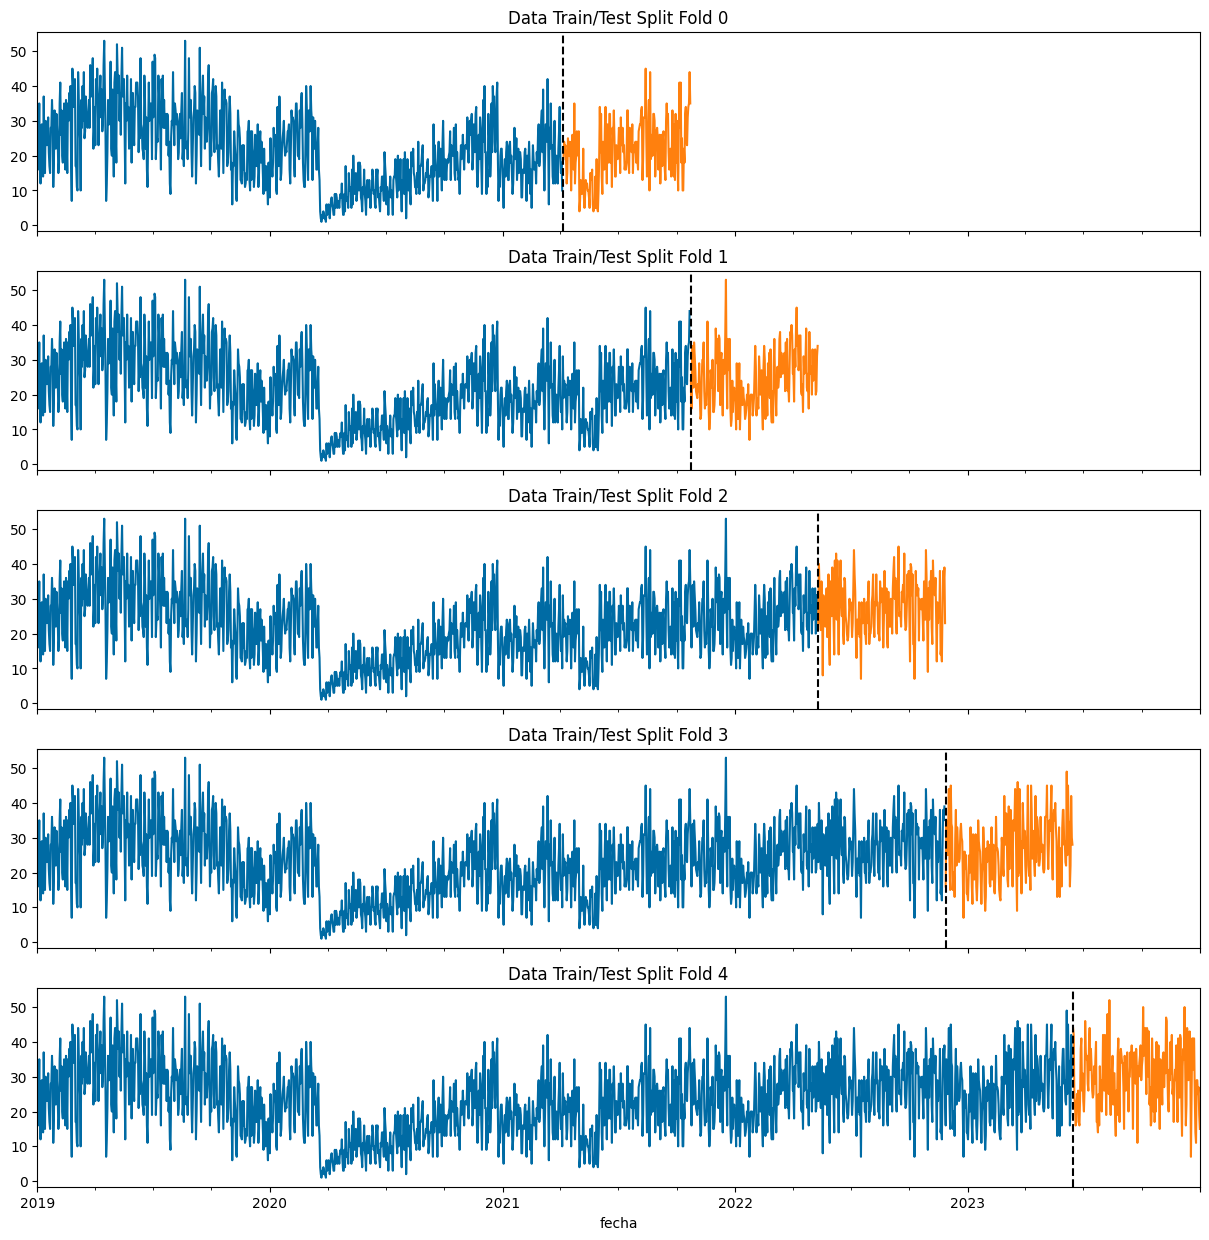

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_siniestros.split(df_siniestros_cv):
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]
    train['cantidad_eventos'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['cantidad_eventos'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss_siniestros

TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=200)

In [ ]:
for i, (train_index, test_index) in enumerate(tss_siniestros.split(df_siniestros_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df_siniestros_cv = create_features(df_siniestros_cv)

In [ ]:
def add_lags(df):
    target_map = df['cantidad_eventos'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df_siniestros_cv = add_lags(df_siniestros_cv)

In [ ]:
df_siniestros_cv.head(3)

,cantidad_eventos,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
fecha,,,,,,,,,,,,
2019-01-01,18,0,1,1,1,2019,1,1,1,NaN,NaN,NaN
2019-01-02,16,0,2,1,1,2019,2,2,1,NaN,NaN,NaN
2019-01-03,24,0,3,1,1,2019,3,3,1,NaN,NaN,NaN


In [ ]:
tss_siniestros_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_siniestros_cv = df_siniestros_cv.sort_index()

In [ ]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_siniestros_2.split(df_siniestros_cv): #Iterar sobre las particiones
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = 'cantidad_eventos'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10.72343	validation_0-mae:8.78479	validation_1-rmse:8.66924	validation_1-mae:7.04428


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:26] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:7.57678	validation_0-mae:5.99368	validation_1-rmse:9.14662	validation_1-mae:7.39160
[200]	validation_0-rmse:6.72825	validation_0-mae:5.19142	validation_1-rmse:9.05097	validation_1-mae:7.31285
[300]	validation_0-rmse:6.41834	validation_0-mae:4.90523	validation_1-rmse:9.00338	validation_1-mae:7.30798
[400]	validation_0-rmse:6.24619	validation_0-mae:4.75674	validation_1-rmse:8.97475	validation_1-mae:7.29652
[500]	validation_0-rmse:6.10861	validation_0-mae:4.63473	validation_1-rmse:8.74947	validation_1-mae:7.10669
[600]	validation_0-rmse:6.02094	validation_0-mae:4.55279	validation_1-rmse:8.83730	validation_1-mae:7.16783
[700]	validation_0-rmse:5.91563	validation_0-mae:4.45985	validation_1-rmse:8.87836	validation_1-mae:7.19299
[800]	validation_0-rmse:5.80611	validation_0-mae:4.36608	validation_1-rmse:8.91354	validation_1-mae:7.22781
[900]	validation_0-rmse:5.68267	validation_0-mae:4.27318	validation_1-rmse:8.97586	validation_1-mae:7.28724
[999]	validation_0-rmse:5.59

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:6.74105	validation_0-mae:5.27219	validation_1-rmse:9.35887	validation_1-mae:7.28239
[400]	validation_0-rmse:6.52105	validation_0-mae:5.07266	validation_1-rmse:9.39088	validation_1-mae:7.29461
[500]	validation_0-rmse:6.32318	validation_0-mae:4.89201	validation_1-rmse:9.48240	validation_1-mae:7.39223
[600]	validation_0-rmse:6.14601	validation_0-mae:4.72694	validation_1-rmse:9.66918	validation_1-mae:7.51475
[700]	validation_0-rmse:6.02110	validation_0-mae:4.61008	validation_1-rmse:9.78675	validation_1-mae:7.59725
[800]	validation_0-rmse:5.94560	validation_0-mae:4.53288	validation_1-rmse:9.80923	validation_1-mae:7.62253
[900]	validation_0-rmse:5.85959	validation_0-mae:4.45284	validation_1-rmse:9.86440	validation_1-mae:7.66929
[999]	validation_0-rmse:5.71632	validation_0-mae:4.34000	validation_1-rmse:9.97722	validation_1-mae:7.74403
[0]	validation_0-rmse:10.07582	validation_0-mae:8.21304	validation_1-rmse:9.47461	validation_1-mae:7.70149
[100]	validation_0-rmse:8.050

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:29] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:7.08429	validation_0-mae:5.58269	validation_1-rmse:7.95991	validation_1-mae:6.38534
[400]	validation_0-rmse:6.87144	validation_0-mae:5.39588	validation_1-rmse:7.91861	validation_1-mae:6.34754
[500]	validation_0-rmse:6.68182	validation_0-mae:5.22444	validation_1-rmse:7.82485	validation_1-mae:6.26247
[600]	validation_0-rmse:6.48183	validation_0-mae:5.04171	validation_1-rmse:7.59869	validation_1-mae:6.05357
[700]	validation_0-rmse:6.35306	validation_0-mae:4.92639	validation_1-rmse:7.48410	validation_1-mae:5.97321
[800]	validation_0-rmse:6.27140	validation_0-mae:4.85454	validation_1-rmse:7.44397	validation_1-mae:5.94250
[900]	validation_0-rmse:6.16786	validation_0-mae:4.76341	validation_1-rmse:7.28814	validation_1-mae:5.81645
[999]	validation_0-rmse:6.09868	validation_0-mae:4.70181	validation_1-rmse:7.24666	validation_1-mae:5.78655
[0]	validation_0-rmse:9.97200	validation_0-mae:8.16220	validation_1-rmse:9.58734	validation_1-mae:7.67605
[100]	validation_0-rmse:8.0749

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:30] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.75974	validation_0-mae:5.30415	validation_1-rmse:9.11147	validation_1-mae:6.87551
[500]	validation_0-rmse:6.56341	validation_0-mae:5.13271	validation_1-rmse:9.14884	validation_1-mae:6.81789
[600]	validation_0-rmse:6.38814	validation_0-mae:4.97675	validation_1-rmse:9.25728	validation_1-mae:6.85662
[700]	validation_0-rmse:6.25628	validation_0-mae:4.85784	validation_1-rmse:9.32409	validation_1-mae:6.87541
[800]	validation_0-rmse:6.15370	validation_0-mae:4.76473	validation_1-rmse:9.38678	validation_1-mae:6.90074
[900]	validation_0-rmse:6.05404	validation_0-mae:4.67988	validation_1-rmse:9.68918	validation_1-mae:7.11696
[999]	validation_0-rmse:5.95695	validation_0-mae:4.60048	validation_1-rmse:9.96825	validation_1-mae:7.32604
[0]	validation_0-rmse:9.91304	validation_0-mae:8.11711	validation_1-rmse:11.21255	validation_1-mae:9.25115
[100]	validation_0-rmse:8.02248	validation_0-mae:6.42303	validation_1-rmse:9.40692	validation_1-mae:7.67271
[200]	validation_0-rmse:7.459

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:30] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.87698	validation_0-mae:5.38974	validation_1-rmse:7.88500	validation_1-mae:6.32446
[500]	validation_0-rmse:6.68704	validation_0-mae:5.22861	validation_1-rmse:7.70953	validation_1-mae:6.15111
[600]	validation_0-rmse:6.53630	validation_0-mae:5.09858	validation_1-rmse:7.64810	validation_1-mae:6.08099
[700]	validation_0-rmse:6.42649	validation_0-mae:5.00276	validation_1-rmse:7.60649	validation_1-mae:6.03948
[800]	validation_0-rmse:6.34241	validation_0-mae:4.92968	validation_1-rmse:7.57120	validation_1-mae:5.99795
[900]	validation_0-rmse:6.24302	validation_0-mae:4.84435	validation_1-rmse:7.58361	validation_1-mae:6.00634
[999]	validation_0-rmse:6.17176	validation_0-mae:4.78168	validation_1-rmse:7.56990	validation_1-mae:5.98840


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.7535
Fold scores:[np.float64(9.005486829138398), np.float64(9.977221677029037), np.float64(7.2466646612188566), np.float64(9.968252522363656), np.float64(7.569902060516407)]


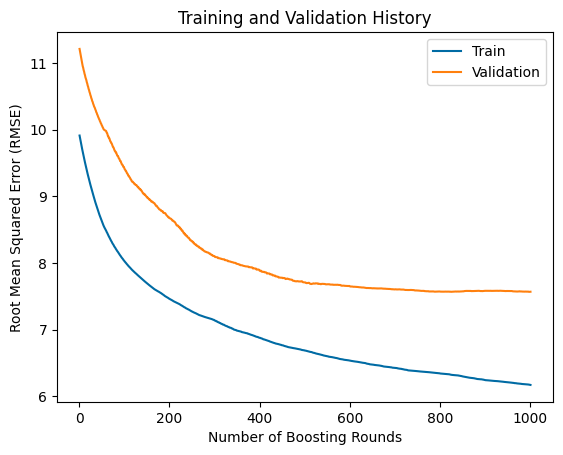

In [ ]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

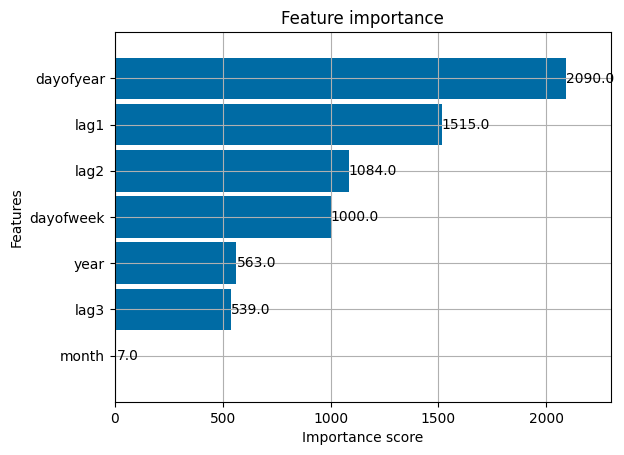

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
y_pred

array([31.672134 , 31.92372  , 24.661922 , 14.929623 , 31.911171 ,
       32.312225 , 34.75364  , 31.895859 , 32.438076 , 24.388754 ,
       17.974316 , 31.25668  , 31.116299 , 31.719484 , 31.659716 ,
       31.772085 , 20.553198 , 19.332201 , 31.071383 , 32.292984 ,
       30.523264 , 33.00002  , 32.239655 , 19.90751  , 19.305956 ,
       29.823807 , 30.890888 , 31.57996  , 31.633322 , 31.894701 ,
       24.095047 , 18.24592  , 31.161789 , 31.121794 , 32.39227  ,
       31.746933 , 31.767645 , 24.23251  , 15.469797 , 31.051857 ,
       30.87434  , 32.397186 , 31.49189  , 34.87072  , 24.108192 ,
       17.069826 , 31.37758  , 31.059227 , 31.902851 , 31.55214  ,
       33.84128  , 20.555191 , 17.996067 , 30.411999 , 32.005554 ,
       33.72912  , 32.694405 , 29.418163 , 20.595436 , 17.996067 ,
       29.55678  , 32.209858 , 30.01621  , 32.003067 , 29.088133 ,
       24.638527 , 17.410774 , 31.497196 , 31.99478  , 32.81379  ,
       32.694405 , 31.869461 , 24.1896   , 17.410774 , 31.1438

In [ ]:
val['prediction'] = reg.predict(X_val)

/tmp/ipython-input-1799221841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [ ]:
val['prediction']

,prediction
fecha,
2023-06-15,31.672134
2023-06-16,31.923719
2023-06-17,24.661922
2023-06-18,14.929623
2023-06-19,31.911171
...,...
2023-12-27,26.831644
2023-12-28,26.872234
2023-12-29,25.024164


In [ ]:
val

,cantidad_eventos,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
fecha,,,,,,,,,,,,,
2023-06-15,44,0,3,2,6,2023,166,15,24,28.0,32.0,16.0,31.672134
2023-06-16,42,0,4,2,6,2023,167,16,24,25.0,32.0,8.0,31.923719
2023-06-17,24,0,5,2,6,2023,168,17,24,33.0,18.0,9.0,24.661922
2023-06-18,22,0,6,2,6,2023,169,18,24,20.0,24.0,6.0,14.929623
2023-06-19,16,0,0,2,6,2023,170,19,25,17.0,11.0,4.0,31.911171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,29,0,2,4,12,2023,361,27,52,21.0,21.0,22.0,26.831644
2023-12-28,25,0,3,4,12,2023,362,28,52,25.0,22.0,16.0,26.872234
2023-12-29,27,0,4,4,12,2023,363,29,52,14.0,19.0,10.0,25.024164


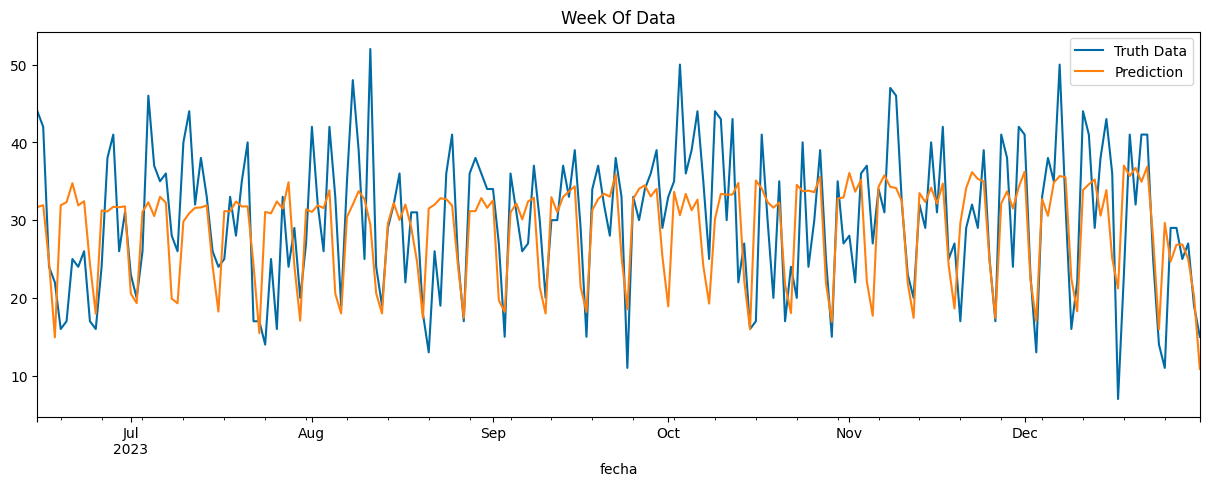

In [ ]:
ax = val.loc[(val.index >= '2017-08-03')]['cantidad_eventos'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 57.30341720581055
Mean Absolute Error (MAE): 5.988396644592285
RMSE Score on Test set: 7.57


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.9 MB/s eta 0:00:00


In [ ]:
import optuna

[I 2025-10-02 16:30:17,256] A new study created in memory with name: no-name-f895eb8b-719a-4d5c-9e7e-9021ac9671f8
[I 2025-10-02 16:30:25,519] Trial 0 finished with value: 7.472651627368937 and parameters: {'n_estimators': 768, 'max_depth': 10, 'learning_rate': 0.051819211080095635, 'subsample': 0.6624720918207189, 'colsample_bytree': 0.6559149282449962, 'reg_alpha': 0.00032065274964761513, 'reg_lambda': 2.9045590500027185e-08}. Best is trial 0 with value: 7.472651627368937.
[I 2025-10-02 16:30:26,513] Trial 1 finished with value: 7.460827214907992 and parameters: {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.032514968393904296, 'subsample': 0.9270506479634666, 'colsample_bytree': 0.9265607971625178, 'reg_alpha': 1.1034741088377272e-06, 'reg_lambda': 0.4300975728907606}. Best is trial 1 with value: 7.460827214907992.
[I 2025-10-02 16:30:31,807] Trial 2 finished with value: 7.7357479324697405 and parameters: {'n_estimators': 465, 'max_depth': 6, 'learning_rate': 0.091537519064

Best hyperparameters:  {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.032514968393904296, 'subsample': 0.9270506479634666, 'colsample_bytree': 0.9265607971625178, 'reg_alpha': 1.1034741088377272e-06, 'reg_lambda': 0.4300975728907606}
Best RMSE:  7.460827214907992


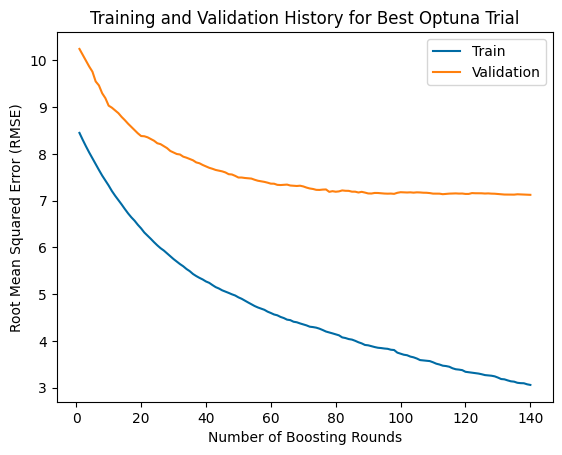

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_siniestros_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = 'cantidad_eventos'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

## Entrenamiento del modelo final

Entrenar el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna en el conjunto de datos completo de entrenamiento.

In [ ]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'cantidad_eventos'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_siniestros_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9265607971625178, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.032514968393904296,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 8.07
Final Model MAE on Test Set: 6.40


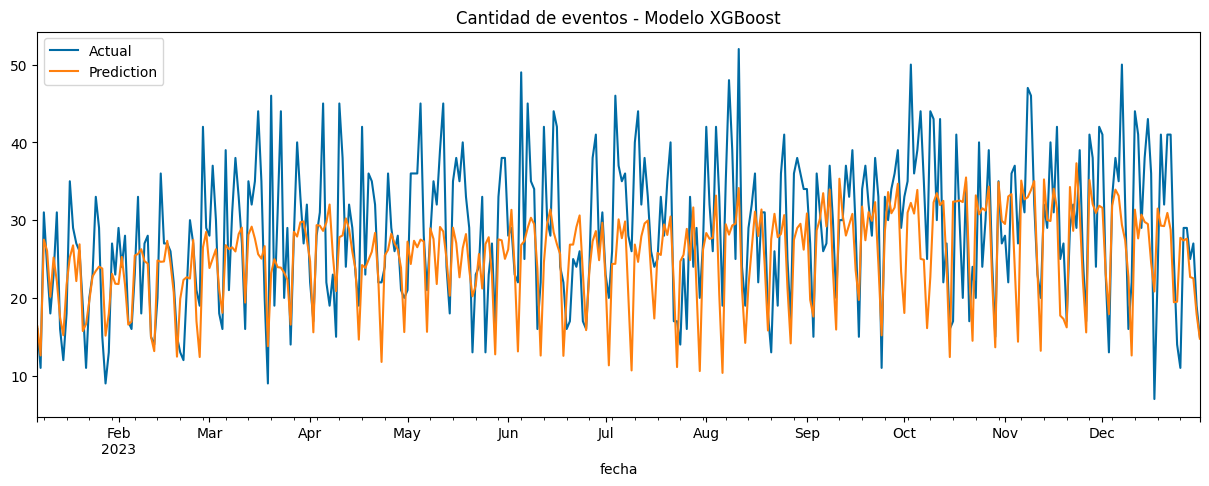

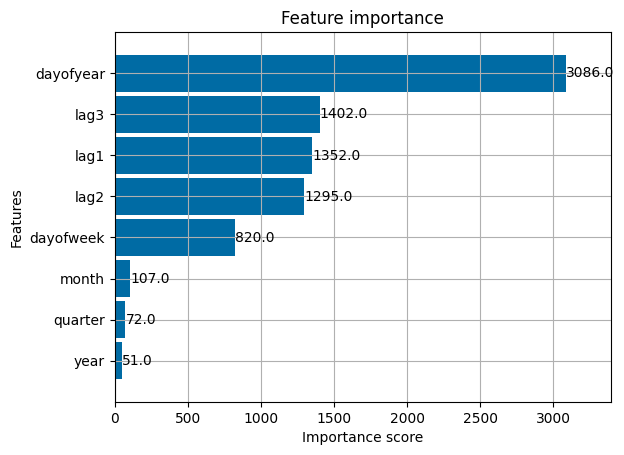

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Cantidad de eventos - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [ ]:
!pip install -e ./timesfm -q

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for timesfm (pyproject.toml) ... done


IMPORTANTE: En este punto reiniciar session de colab antes de descargar los pesos del modelo

In [ ]:
# 2. Importaciones y carga del modelo
import timesfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True, # Importante para siniestros, que no pueden ser negativos
        fix_quantile_crossing=True,
    )
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/925M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 3. Preparación de tus datos
HORIZON = 30 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_siniestros_TFM = df_siniestros.copy()
split_index = int(len(data_siniestros_TFM) * 0.8)
train_siniestros_TFM = data_siniestros_TFM[:split_index]
test_siniestros_TFM = data_siniestros_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_siniestros_TFM['cantidad_eventos'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [ ]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_siniestros = point_forecast[0]

print(f"Se generaron {len(prediccion_siniestros)} predicciones para los próximos {HORIZON} días.")

Se generaron 30 predicciones para los próximos 30 días.


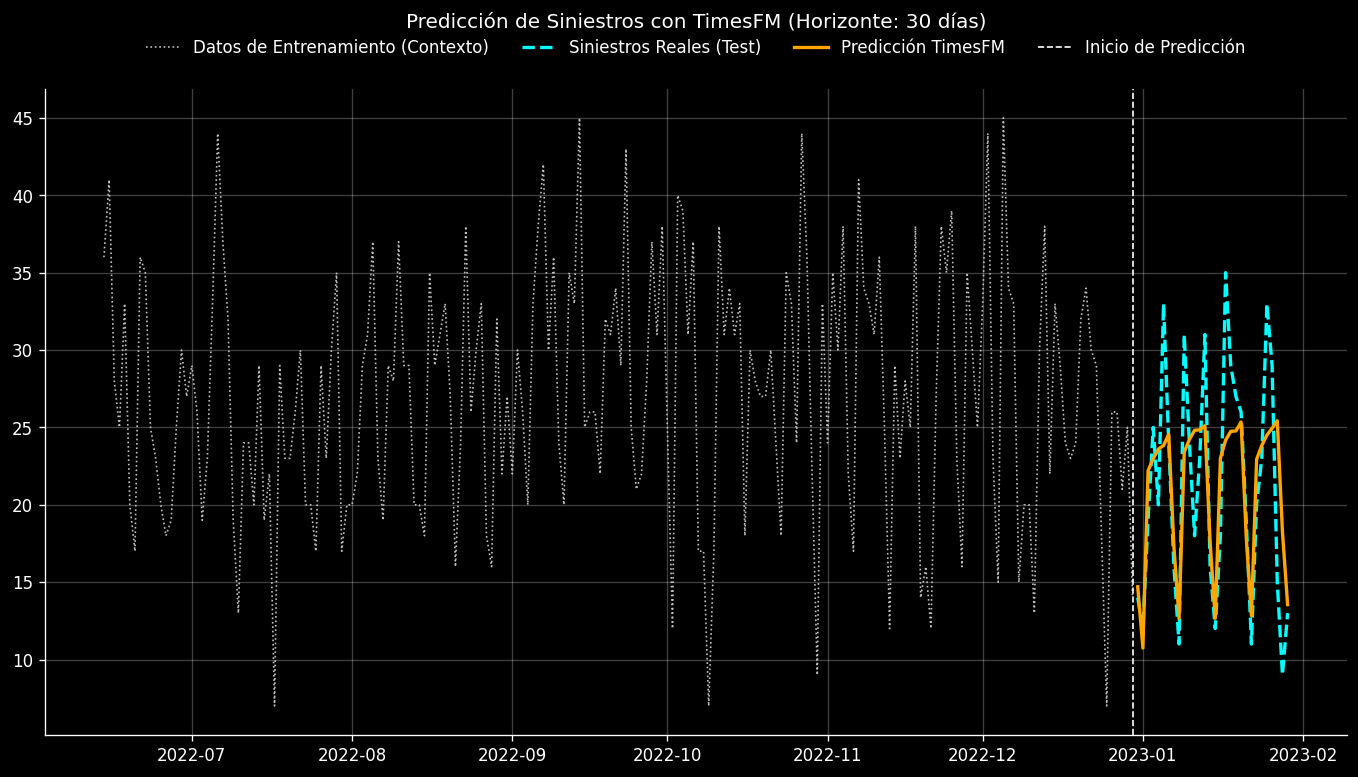

In [ ]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_siniestros_TFM['cantidad_eventos'].iloc[:HORIZON].values,
    'Predichos': prediccion_siniestros
}, index=test_siniestros_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_siniestros_TFM.index[-200:], train_siniestros_TFM['cantidad_eventos'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Siniestros Reales (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_siniestros_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Siniestros con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_resultados['Reales'], df_resultados['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.68
Raíz del Error Cuadrático Medio (RMSE): 4.92


## TimesFM_2

Forma de los datos de entrada para el modelo: (4, 365)
Se generaron 30 predicciones para los próximos 30 días.


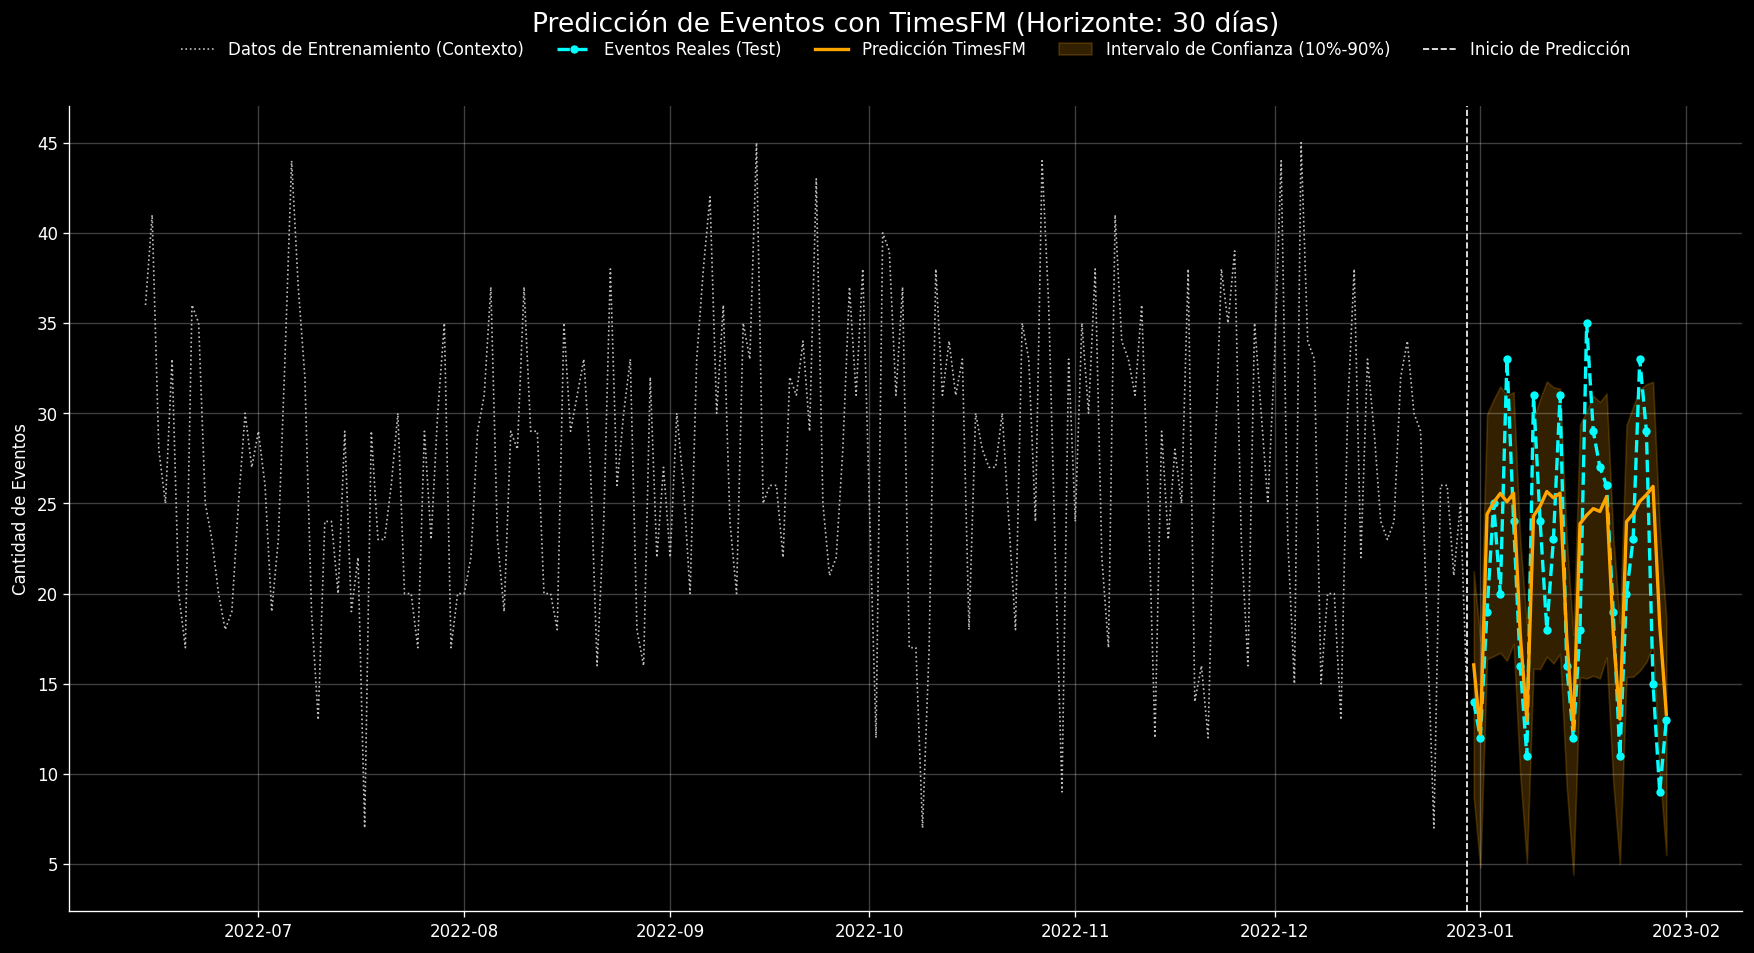

In [ ]:
from sklearn.preprocessing import StandardScaler
# Configurar el modelo para la inferencia
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)

# ==============================================================================
# PASO 2: PREPARACIÓN DE DATOS Y FEATURE ENGINEERING
# ==============================================================================
# --- Asegúrate de que tu DataFrame 'df_siniestros' esté cargado aquí ---
# Por ejemplo:
# df_siniestros = pd.read_csv('tus_datos.csv', parse_dates=['fecha'], index_col='fecha')


# Definir la columna objetivo y el horizonte
TARGET_COLUMN = 'cantidad_eventos'
HORIZON = 30
CONTEXT_WINDOW = 365 # Puedes experimentar cambiando este valor (ej. 365)

# Crear características basadas en la fecha
# Es crucial que el índice de tu DataFrame sea de tipo DatetimeIndex
df_siniestros_featured = df_siniestros.copy()
df_siniestros_featured['dia_de_semana'] = df_siniestros_featured.index.dayofweek
df_siniestros_featured['dia_del_mes'] = df_siniestros_featured.index.day
df_siniestros_featured['mes'] = df_siniestros_featured.index.month

# Normalizar las nuevas características
scaler = StandardScaler()
features_to_scale = ['dia_de_semana', 'dia_del_mes', 'mes']
df_siniestros_featured[features_to_scale] = scaler.fit_transform(
    df_siniestros_featured[features_to_scale]
)

# Dividir en datos de entrenamiento y prueba
split_index = int(len(df_siniestros_featured) * 0.8)
train_data = df_siniestros_featured[:split_index]
test_data = df_siniestros_featured[split_index:]

# ==============================================================================
# PASO 3: PREPARAR INPUTS PARA EL MODELO
# ==============================================================================
# Definir las columnas que usaremos, con la objetivo SIEMPRE PRIMERO
feature_columns = [TARGET_COLUMN] + features_to_scale

# Extraer el contexto del final del set de entrenamiento
context_data = train_data[feature_columns][-CONTEXT_WINDOW:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs = context_data.T

print(f"Forma de los datos de entrada para el modelo: {model_inputs.shape}")

# ==============================================================================
# PASO 4: REALIZAR LA PREDICCIÓN
# ==============================================================================
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=model_inputs
)

# Extraer la predicción principal y los cuantiles para el intervalo de confianza
predicted_values = point_forecast[0]
q10 = quantile_forecast[0, :, 1] # Cuantil 10
q90 = quantile_forecast[0, :, 8] # Cuantil 90

print(f"Se generaron {len(predicted_values)} predicciones para los próximos {HORIZON} días.")

# ==============================================================================
# PASO 5: VISUALIZACIÓN DE RESULTADOS
# ==============================================================================
# Crear un DataFrame para facilitar la comparación
df_results = pd.DataFrame({
    'Reales': test_data[TARGET_COLUMN].iloc[:HORIZON].values,
    'Predichos': predicted_values,
    'Cuantil_10': q10,
    'Cuantil_90': q90
}, index=test_data.index[:HORIZON])

# Graficar los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8), dpi=120)

# 1. Datos de entrenamiento (últimos 200 puntos como contexto)
ax.plot(train_data.index[-200:], train_data[TARGET_COLUMN][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# 2. Datos reales del período de prueba
ax.plot(df_results.index, df_results['Reales'],
        ls='--', lw=2, marker='o', markersize=4, color='cyan', label='Eventos Reales (Test)')

# 3. Predicción puntual del modelo
ax.plot(df_results.index, df_results['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# 4. Intervalo de confianza
ax.fill_between(df_results.index, df_results['Cuantil_10'], df_results['Cuantil_90'],
                color='orange', alpha=0.2, label='Intervalo de Confianza (10%-90%)')

# 5. Línea vertical para marcar el inicio de la predicción
ax.axvline(train_data.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.legend(frameon=False, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Eventos con TimesFM (Horizonte: {HORIZON} días)", y=1.08, fontsize=16)
ax.set_ylabel("Cantidad de Eventos")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.86
Raíz del Error Cuadrático Medio (RMSE): 5.02


# Precipitaciones

In [ ]:
df_precipitaciones.rename(columns={'Unnamed: 0': 'fecha'}, inplace=True)
df_precipitaciones.head()

,fecha,(mm)
0,2019-01-01,2.0
1,2019-01-02,9.0
2,2019-01-03,0.0
3,2019-01-04,0.0
4,2019-01-05,1.0


# Temperatura

In [ ]:
df_temperatura.rename(columns={'Unnamed: 0': 'fecha', '(°C)': 'Maxima', 'Unnamed: 2': 'Minima'}, inplace=True)
df_temperatura.head()

,fecha,Maxima,Minima
0,2019-01-01,32.7,23.4
1,2019-01-02,32.1,23.7
2,2019-01-03,26.3,17
3,2019-01-04,28.9,18
4,2019-01-05,30.1,21.2


In [ ]:
mask = (df_temperatura['Maxima'].isin(['\\N', 'N'])) | (df_temperatura['Minima'].isin(['\\N', 'N']))

In [ ]:
# 1. Reemplazar '\\N' (y posiblemente 'N') por NaN
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].replace({'\\N': np.nan, 'N': np.nan})

# 2. Convertir a float
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].astype(float)

# 3. Verificar los tipos
print(df_temperatura.dtypes)
print(df_temperatura.isna().sum())
df_temperatura.dropna(inplace=True)
print(df_temperatura.isna().sum())
print(df_temperatura.dtypes)


fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object
fecha     0
Maxima    1
Minima    1
dtype: int64
fecha     0
Maxima    0
Minima    0
dtype: int64
fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object


In [ ]:
df_temperatura['Media']= (df_temperatura['Maxima'] + df_temperatura['Minima']) / 2

In [ ]:
df_temperatura.set_index('fecha', inplace=True)

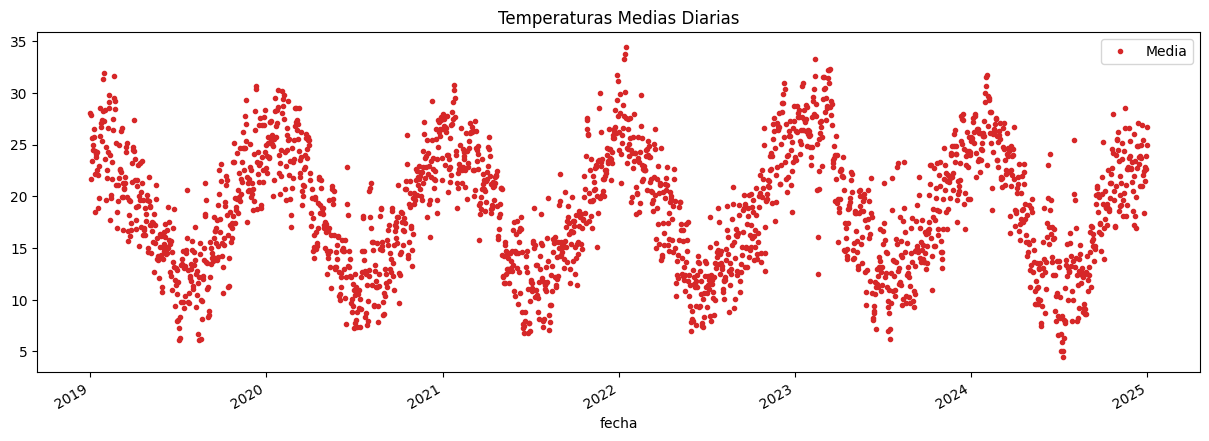

In [ ]:
# Seleccionar la temperatura media como nuestro objetivo a predecir
df_modelo_temp = df_temperatura[['Media']].copy()

# Visualización de la nueva serie temporal de temperatura media
df_modelo_temp.plot(style='.',
                    figsize=(15, 5),
                    color=color_pal[3],
                    title='Temperaturas Medias Diarias')
plt.show()

In [ ]:
def create_features(df):
    """
    Crea características temporales a partir del índice de tipo datetime de un DataFrame.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_modelo_temp = create_features(df_modelo_temp)

In [ ]:
# Usamos TimeSeriesSplit para la validación cruzada
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

scores = []
fold = 0
for train_idx, val_idx in tss.split(df_modelo_temp):
    train = df_modelo_temp.iloc[train_idx]
    test = df_modelo_temp.iloc[val_idx]

    # ¡IMPORTANTE! Se define la variable 'Media' como objetivo
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
    TARGET = 'Media'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False) # Se cambia a False para no imprimir el log de cada fold

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f'Fold {fold} RMSE: {score}')
    fold += 1

print(f'\nPromedio de RMSE en todos los folds: {np.mean(scores):.4f}')


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:11:52] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 0 RMSE: 3.29685867653691


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:11:52] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 1 RMSE: 3.1779646497276786


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:11:52] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 2 RMSE: 3.295461221320478


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:11:53] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 3 RMSE: 3.9115707870891017


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:11:53] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 4 RMSE: 3.4202078820940183

Promedio de RMSE en todos los folds: 3.4204


[0]	validation_0-rmse:18.79457	validation_1-rmse:19.41684
[100]	validation_0-rmse:7.49566	validation_1-rmse:8.24098
[200]	validation_0-rmse:3.89277	validation_1-rmse:4.78093


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:12:06] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:3.04320	validation_1-rmse:3.93876
[400]	validation_0-rmse:2.86577	validation_1-rmse:3.76344
[500]	validation_0-rmse:2.80160	validation_1-rmse:3.73630
[527]	validation_0-rmse:2.79017	validation_1-rmse:3.73806


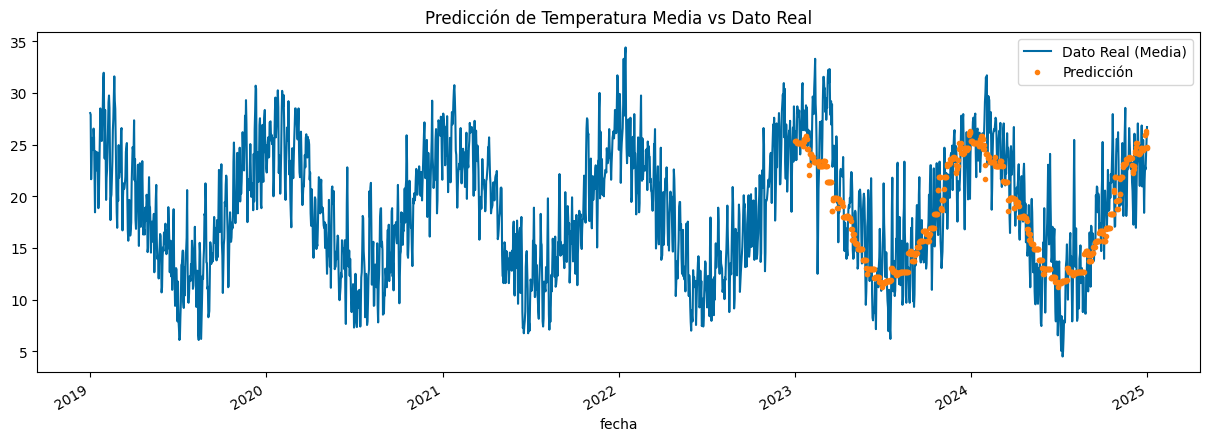

RMSE en el conjunto de prueba final: 3.7337


In [ ]:
# Dividimos en conjunto de entrenamiento y prueba para el modelo final
split_date = '01-Jan-2023'
train = df_modelo_temp.loc[df_modelo_temp.index <= split_date].copy()
test = df_modelo_temp.loc[df_modelo_temp.index > split_date].copy()

# Entrenamos el modelo final con todos los datos de entrenamiento
X_train_final = train[FEATURES]
y_train_final = train[TARGET]
X_test_final = test[FEATURES]
y_test_final = test[TARGET]

reg_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg_final.fit(X_train_final, y_train_final,
        eval_set=[(X_train_final, y_train_final), (X_test_final, y_test_final)],
        verbose=100)

# Realizamos la predicción en el conjunto de prueba
test['prediction'] = reg_final.predict(X_test_final)
df_final = df_modelo_temp.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Visualización de la predicción vs los datos reales
ax = df_final[['Media']].plot(figsize=(15, 5))
df_final['prediction'].plot(ax=ax, style='.')
plt.legend(['Dato Real (Media)', 'Predicción'])
ax.set_title('Predicción de Temperatura Media vs Dato Real')
plt.show()

# Calculamos el error final
score_final = np.sqrt(mean_squared_error(test['Media'], test['prediction']))
print(f'RMSE en el conjunto de prueba final: {score_final:.4f}')

[I 2025-10-02 18:24:43,180] A new study created in memory with name: no-name-152b548e-bf30-4760-a13e-c0a93468886f
[I 2025-10-02 18:24:50,251] Trial 0 finished with value: 5.746359784855256 and parameters: {'n_estimators': 904, 'max_depth': 8, 'learning_rate': 0.09342910782449103, 'subsample': 0.7799624176362133, 'colsample_bytree': 0.7544574205978637, 'reg_alpha': 0.00017912248279083727, 'reg_lambda': 0.0012420441582452128}. Best is trial 0 with value: 5.746359784855256.
[I 2025-10-02 18:24:55,074] Trial 1 finished with value: 5.786568142317374 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.024824764763780236, 'subsample': 0.8903367069106531, 'colsample_bytree': 0.8342369668294668, 'reg_alpha': 4.501185444140221e-05, 'reg_lambda': 0.00010864334862341114}. Best is trial 0 with value: 5.746359784855256.
[I 2025-10-02 18:24:58,712] Trial 2 finished with value: 5.739608493663103 and parameters: {'n_estimators': 863, 'max_depth': 9, 'learning_rate': 0.0840395845071

Best hyperparameters:  {'n_estimators': 964, 'max_depth': 9, 'learning_rate': 0.017153797044826148, 'subsample': 0.7409292529724852, 'colsample_bytree': 0.8973602971735573, 'reg_alpha': 0.4854704428604095, 'reg_lambda': 1.7772579739677023e-06}
Best RMSE:  5.640635487033502


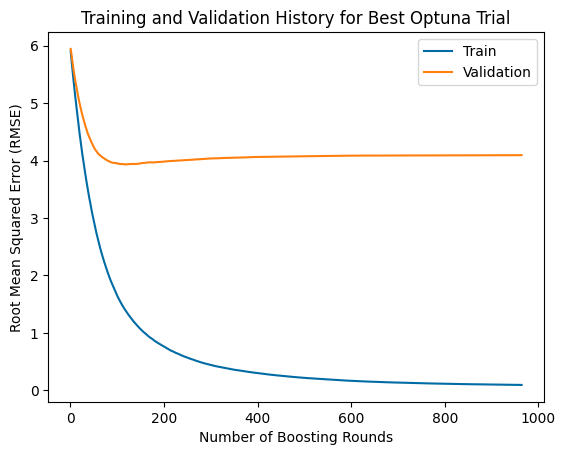

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

# Modify the add_lags function to work with the 'Media' column
def add_lags(df):
    """
    Add lag features to the DataFrame based on the 'Media' column.
    """
    # Check if 'Media' column exists before proceeding
    if 'Media' not in df.columns:
        print("Error: 'Media' column not found in the DataFrame.")
        return df # Return the original DataFrame if the column is missing

    target_map = df['Media'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df


def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    df_processed = create_features(df_modelo_temp.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

    # Calculate compatible test_size for TimeSeriesSplit
    n_samples = len(df_processed)
    n_splits = 5
    gap = 1
    # test_size = int((n_samples - gap) / (n_splits + 1)) -1 # This is one way to calculate test_size
    test_size = 218 # Adjusted test_size to be compatible with the number of samples

    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    rmse_scores = []


    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3'] # Include lag features
    TARGET = 'Media' # Set target to 'Media' for temperature data

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

In [ ]:
# Define features and target
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3']
TARGET = 'Media'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_modelo_temp.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-01-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8973602971735573, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.017153797044826148,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=964, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 4.00
Final Model MAE on Test Set: 3.14


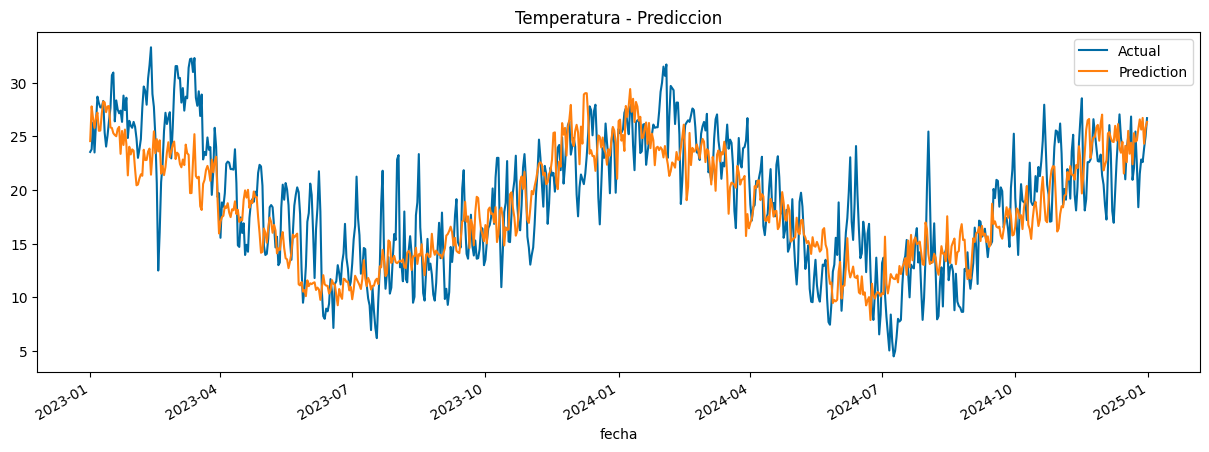

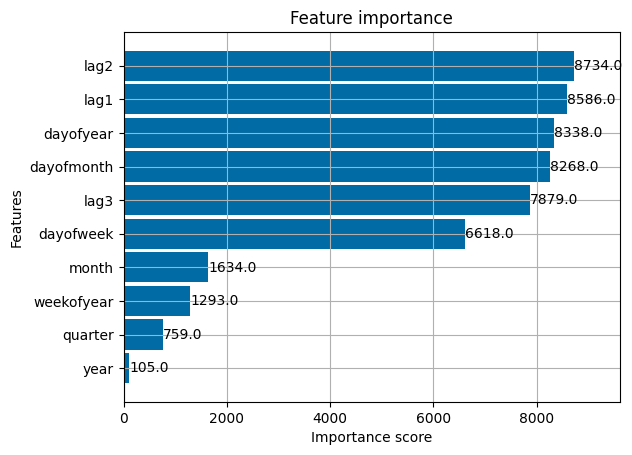

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Temperatura - Prediccion')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [ ]:
# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,    ## <- Aqui modifico la ventana, hay que probar diferentes variantes
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False,
        fix_quantile_crossing=True,
    )
)

In [ ]:
# 3. Preparación de tus datos
HORIZON = 15 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_temperatura_TFM = df_modelo_temp.copy()
split_index = int(len(data_temperatura_TFM) * 0.8)
train_temperatura_TFM = data_temperatura_TFM[:split_index]
test_temperatura_TFM = data_temperatura_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_temperatura_TFM['Media'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [ ]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_temperatura = point_forecast[0]

print(f"Se generaron {len(prediccion_temperatura)} predicciones para los próximos {HORIZON} días.")

Se generaron 15 predicciones para los próximos 15 días.


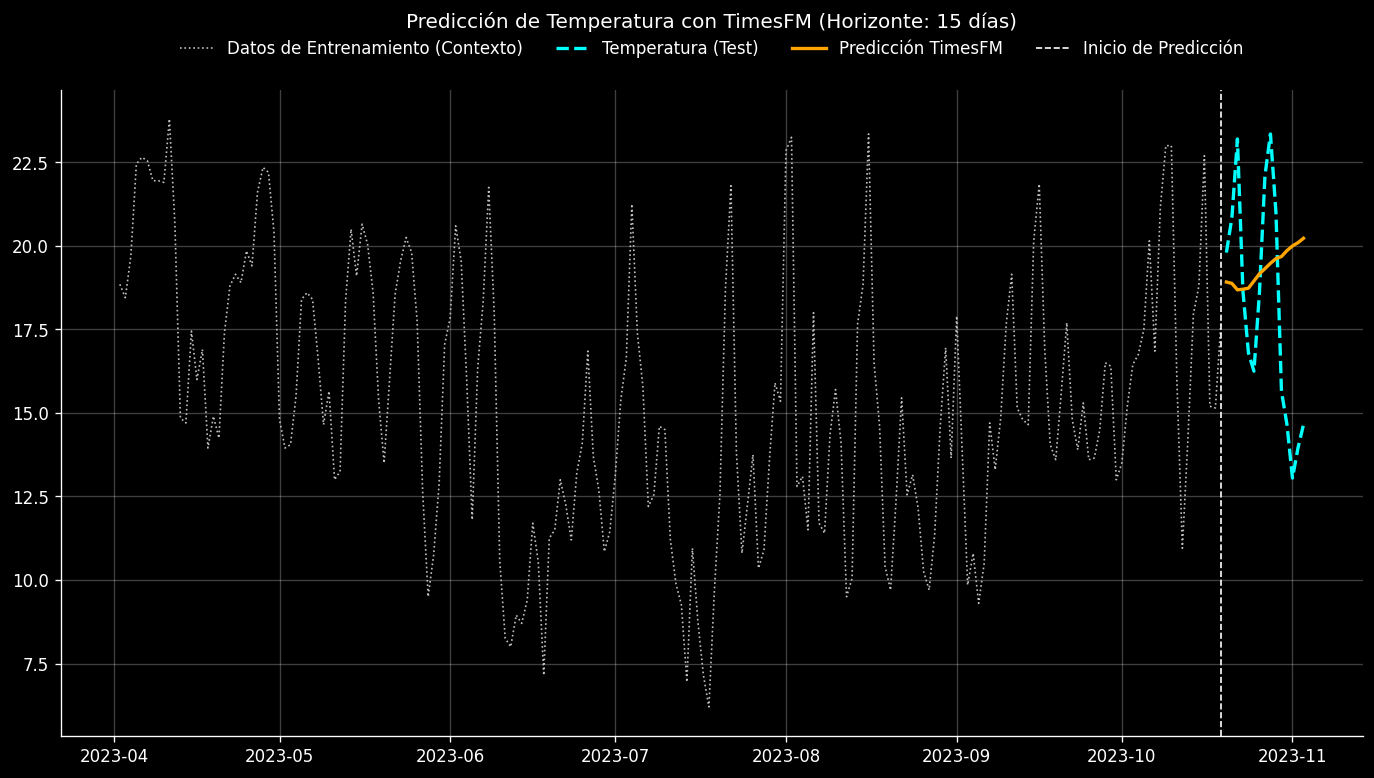

In [ ]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_temperatura_TFM['Media'].iloc[:HORIZON].values,
    'Predichos': prediccion_temperatura
}, index=test_temperatura_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_temperatura_TFM.index[-200:], train_temperatura_TFM['Media'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Temperatura (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_temperatura_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Temperatura con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## TimesFM_2

Forma de los datos de entrada de Temperatura: (4, 730)


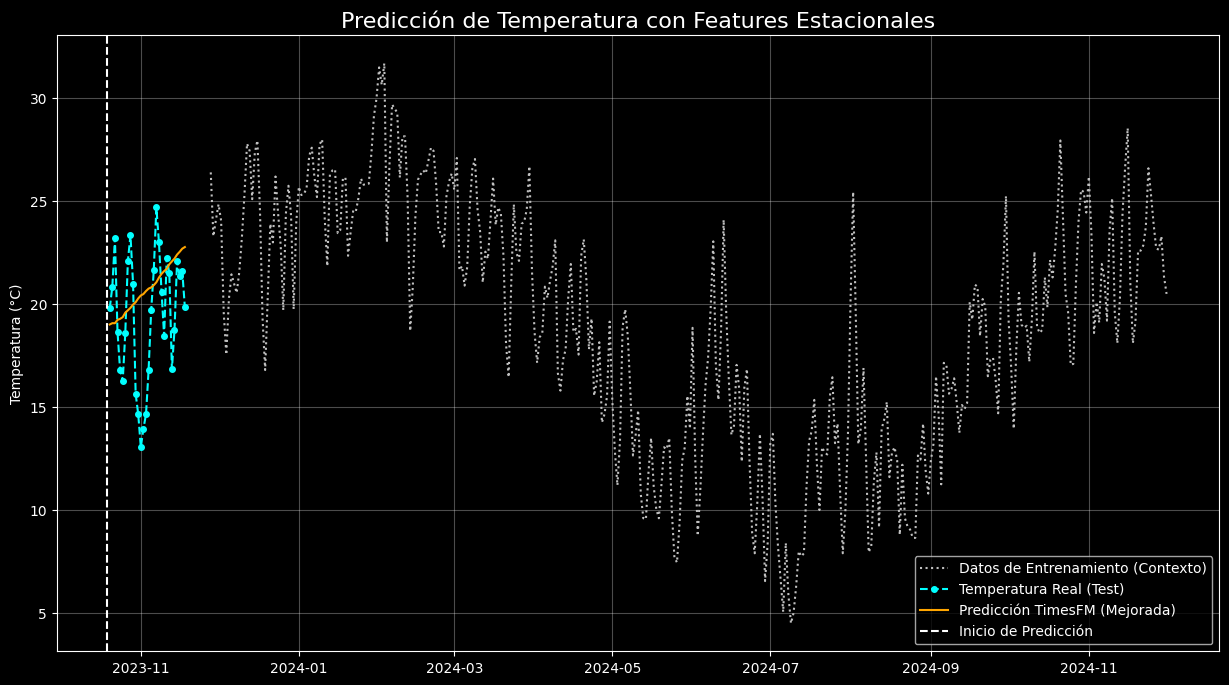

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Hacemos una copia para no modificar el dataframe original
df_temp_featured = df_modelo_temp.copy()

# La característica más importante para la temperatura es el ciclo anual.
# Usamos el día del año y lo transformamos con seno y coseno
# para que el modelo entienda que el día 365 está cerca del día 1.
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

# También añadimos el día de la semana, que puede capturar patrones semanales
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

# --- 2. ESCALADO DE TODAS LAS CARACTERÍSTICAS ---

# Definimos la columna objetivo y las características que usaremos
TARGET_COLUMN_TEMP = 'Media'
# Nota: La columna objetivo también se escala junto con las demás.
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']

# Creamos y ajustamos el escalador a todas las características
scaler_temp = StandardScaler()
df_temp_featured[FEATURES_TEMP] = scaler_temp.fit_transform(df_temp_featured[FEATURES_TEMP])

# --- 3. DIVISIÓN DE DATOS Y PREPARACIÓN DEL INPUT ---
HORIZON_TEMP = 30
CONTEXT_WINDOW_TEMP = 730 # Un año de contexto es ideal para capturar la estacionalidad anual

split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp]
test_data_temp = df_temp_featured[split_index_temp:]

# Extraer el contexto del final del set de entrenamiento
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN DEL MODELO Y PREDICCIÓN ---

# Re-compilamos el modelo con la configuración correcta para temperatura
# La única diferencia es infer_is_positive=False
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False, # ¡Importante! La temperatura puede ser negativa
        fix_quantile_crossing=True,
    )
)

# Realizar la predicción
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP,
    inputs=model_inputs_temp
)

# --- 5. RE-ESCALADO DE LOS RESULTADOS Y VISUALIZACIÓN ---

# El modelo predice valores escalados, ¡debemos revertir la transformación!
# Creamos un array vacío con la misma forma que los datos originales (N, 4 features)
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
# Ponemos la predicción en la primera columna (la de la variable objetivo)
predicted_scaled[:, 0] = point_forecast_temp[0]

# Usamos el método `inverse_transform` del scaler para obtener los valores en la escala original
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)

# La predicción en la escala original está en la primera columna
predicted_values_temp = predicted_unscaled[:, 0]

# También necesitamos los datos reales sin escalar para comparar
reales_unscaled = scaler_temp.inverse_transform(
    test_data_temp[FEATURES_TEMP].iloc[:HORIZON_TEMP]
)[:, 0]

# Crear DataFrame para graficar
df_results_temp = pd.DataFrame({
    'Reales': reales_unscaled,
    'Predichos': predicted_values_temp
}, index=test_data_temp.index[:HORIZON_TEMP])

# Graficar
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_modelo_temp['Media'][-400:-HORIZON_TEMP], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')
ax.plot(df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp['Predichos'], label='Predicción TimesFM (Mejorada)', color='orange', ls='-')
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')
ax.set_title('Predicción de Temperatura con Features Estacionales', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


Forma de los datos de entrada de Temperatura: (4, 1095)


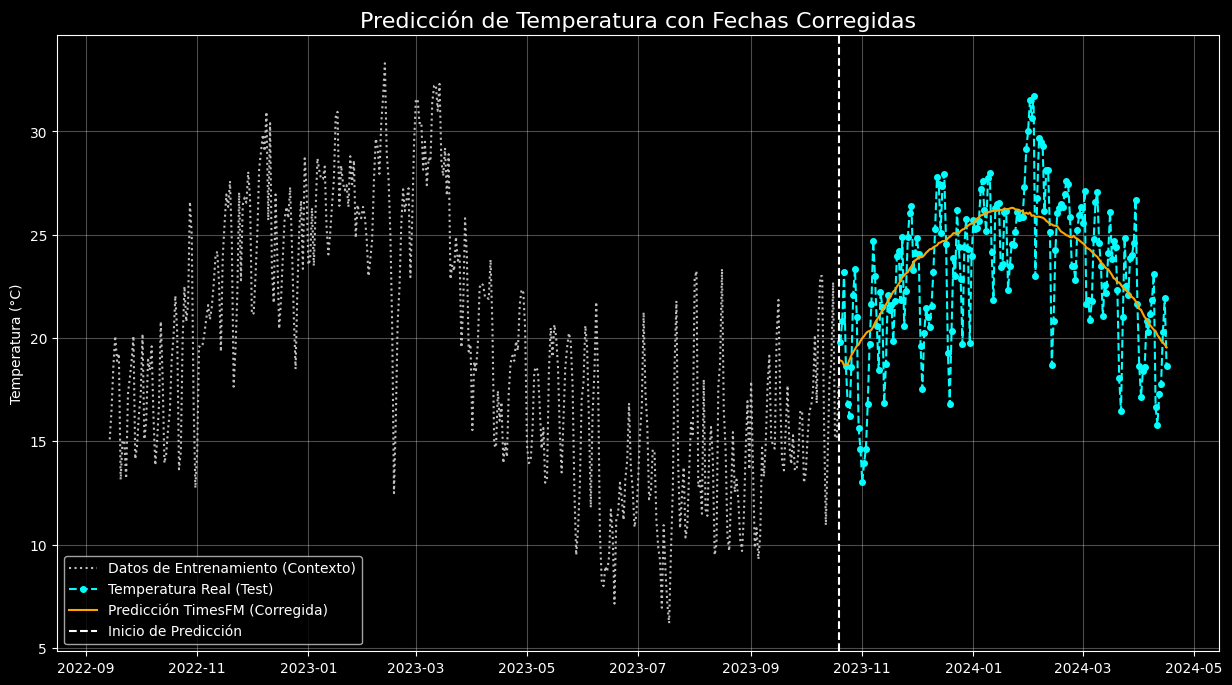

In [30]:
# --- 1. FEATURE ENGINEERING (Esto ya estaba correcto) ---
df_temp_featured = df_modelo_temp.copy()
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

TARGET_COLUMN_TEMP = 'Media'
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']
HORIZON_TEMP = 180 # Set the prediction horizon to 180 days
CONTEXT_WINDOW_TEMP = 1095

# --- 2. DIVISIÓN Y ESCALADO CORRECTOS (¡AQUÍ ESTÁ EL CAMBIO!) ---

# **PASO 2.1: PRIMERO, dividimos los datos**
split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp].copy() # Usamos .copy() para evitar warnings
test_data_temp = df_temp_featured[split_index_temp:].copy()

# **PASO 2.2: LUEGO, creamos y AJUSTAMOS el escalador SOLO CON DATOS DE ENTRENAMIENTO**
scaler_temp = StandardScaler()
scaler_temp.fit(train_data_temp[FEATURES_TEMP])

# **PASO 2.3: AHORA, transformamos ambos conjuntos de datos por separado**
train_data_temp[FEATURES_TEMP] = scaler_temp.transform(train_data_temp[FEATURES_TEMP])
test_data_temp[FEATURES_TEMP] = scaler_temp.transform(test_data_temp[FEATURES_TEMP])

# --- 3. PREPARACIÓN DEL INPUT (Sin cambios, pero ahora usa datos bien escalados) ---
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN (Sin cambios) ---
model.compile(
    timesfm.ForecastConfig(
        max_context=1024, max_horizon=512, normalize_inputs=True,
        use_continuous_quantile_head=True, force_flip_invariance=True,
        infer_is_positive=False, fix_quantile_crossing=True,
    )
)
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP, inputs=model_inputs_temp # Use HORIZON_TEMP for the prediction horizon
)

# --- CORRECCIÓN CLAVE: Construcción robusta del DataFrame de resultados ---

# 1. Obtenemos el índice de fechas exacto para el período de la predicción.
prediction_index = test_data_temp.index[:HORIZON_TEMP]

# 2. Get the unscaled predicted values
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
predicted_scaled[:, 0] = point_forecast_temp[0]
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)
predicted_values_temp = predicted_unscaled[:, 0]

# 3. Obtenemos los valores reales correspondientes a ESE índice desde el DataFrame ORIGINAL (no escalado).
real_values = df_modelo_temp.loc[prediction_index, TARGET_COLUMN_TEMP]

# 4. Creamos el DataFrame de resultados asegurando que todo esté alineado.
df_results_temp = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values_temp
}, index=prediction_index)


# --- Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original para claridad
ax.plot(df_modelo_temp[TARGET_COLUMN_TEMP].loc[train_data_temp.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción - tomados del nuevo df_results_temp
ax.plot(df_results_temp.index, df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp.index, df_results_temp['Predichos'], label='Predicción TimesFM (Corregida)', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.set_title('Predicción de Temperatura con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()